# Обзор датасета Android_v1
Датасет взят с гитхаба: https://github.com/logpai/loghub

План рассмотрения датасета:
1. Количество записей по времени (плотность распределения событий) для каждого компонента системы.
2. Очистка и анализ текстовых сообщений (семантика)
3. Темплейт логов с помощью drain или spell. Построение распределений
4. Группировка темплейтов + кластеризация

Подключение необходимых библиотек

In [1]:
import pandas as pd
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

## 1. Загрузка датасета

Парсинг строк логов

In [37]:
with open('Android.log', 'r', encoding='utf-8') as f:
    log_lines = f.readlines()

data = []
skipped_lines = 0

# убираю строки с пропусками компонента или сообщения
for log in log_lines:
    parsed_line = log.strip().split(maxsplit=5)
    try:
        log_component, log_message = parsed_line[-1].split(':', maxsplit=1)
    except ValueError:
        skipped_lines += 1
        continue
    parsed_line = parsed_line[:5]
    parsed_line.extend([log_component, log_message])
    parsed_line = list(filter(None, list(map(lambda x: x.strip(), parsed_line))))
    if len(parsed_line) == 7:
        data.append(parsed_line)
    else:
        skipped_lines += 1

print(f'Количество строк с пропусками: {skipped_lines}')

Количество строк с пропусками: 71296


Загрузка логов в датафрейм и первичная обработка временных, числовых и текстовых данных

In [38]:
log_df = pd.DataFrame(data, columns=['month_day', 'time', 'pid', 'tid', 'log_level', 'component', 'log_message'])
log_df['datetime'] = '2023-' + log_df['month_day'] + ' ' + log_df['time']
log_df['datetime'] = pd.to_datetime(log_df['datetime'])
log_df = log_df.astype({'pid': 'int', 'tid': 'int', 'log_level': 'str', 'component': 'str', 'log_message': 'str'})
log_df = log_df[['datetime', 'pid', 'tid', 'log_level', 'component', 'log_message']]
display(log_df)

,datetime,pid,tid,log_level,component,log_message
0,2023-12-17 19:31:36.263,1795,1825,I,PowerManager_screenOn,DisplayPowerStatesetColorFadeLevel: level=1.0
1,2023-12-17 19:31:36.263,5224,5283,I,SendBroadcastPermission,action:android.com.huawei.bone.NOTIFY_SPORT_DA...
2,2023-12-17 19:31:36.264,1795,1825,D,DisplayPowerController,"Animating brightness: target=21, rate=40"
3,2023-12-17 19:31:36.264,1795,1825,I,PowerManager_screenOn,DisplayPowerController updatePowerState mPendi...
4,2023-12-17 19:31:36.264,1795,2750,I,PowerManager_screenOn,DisplayPowerState Updating screen state: state...
...,...,...,...,...,...,...
1483704,2023-12-18 19:53:49.399,2852,2852,I,ToggleSlider,mSeekListener onProgressChanged progress:1574 ...
1483705,2023-12-18 19:53:49.399,2852,2852,I,ToggleSlider,mSeekListener onProgressChanged progress:1574 ...
1483706,2023-12-18 19:53:49.406,1795,2750,I,HwLightsService,back light level before map = 534
1483707,2023-12-18 19:53:49.406,1795,2750,D,HW_DISPLAY_EFFECT,"presently, hw_update_color_temp_for_rg_led int..."


## 2. Основные характеристики датасета

Размер датасета после очистки строк с пропусками

In [39]:
log_df.shape

(1483709, 6)

Пропуски и дубликаты в датасете. Дубликаты не выкидываются, так как один и тот же сервис может присылать одинаковые сообщения

In [40]:
print('Пропуски в датасете:')
print(log_df.isna().sum())
print('Полные дупликаты строк:')
print(log_df.duplicated().sum())

Пропуски в датасете:
datetime       0
pid            0
tid            0
log_level      0
component      0
log_message    0
dtype: int64
Полные дупликаты строк:
93180


Общие характеристики датасета

In [41]:
print(f'Общее количество записей: {len(log_df)}')
print(f'Время начала записей логов: {log_df['datetime'].min()}')
print(f'Время окончания записей логов: {log_df['datetime'].max()}')
print(f'Общее время записей логов: {log_df['datetime'].max() - log_df['datetime'].min()}')
print(f'Количество уникальных процессов: {log_df['pid'].nunique()}')
print(f'Количество уникальных потоков: {log_df['tid'].nunique()}')

Общее количество записей: 1483709
Время начала записей логов: 2023-12-17 19:31:36.263000
Время окончания записей логов: 2023-12-18 19:53:49.423000
Общее время записей логов: 1 days 00:22:13.160000
Количество уникальных процессов: 640
Количество уникальных потоков: 7714


Распределение сообщений по уровню логов

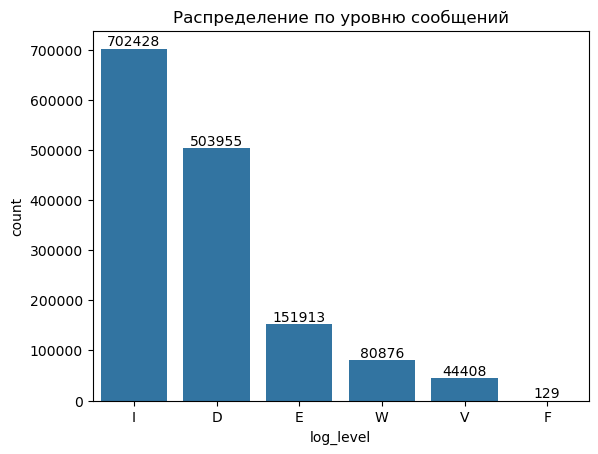

In [42]:
ax = sns.barplot(log_df['log_level'].value_counts())
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Распределение по уровню сообщений')
plt.show()

Наиболее часто встречающиеся процессы

In [43]:
print('Топ 10 процессов')
display(log_df['pid'].value_counts()[:10])

Топ 10 процессов


pid
1795     488296
2852     352089
633       89206
5224      42253
5157      36870
3218      36738
3626      35235
3858      30836
24266     26818
1046      24330
Name: count, dtype: int64

Анализ сообщений

In [44]:
log_df['log_message_len'] = log_df['log_message'].str.len()
print(f'Минимальная длина сообщения: {log_df['log_message_len'].min()}')
print(f'Максимальная длина сообщения: {log_df['log_message_len'].max()}')
print(f'Средняя длина сообщения: {log_df['log_message_len'].mean():.2f}')

Минимальная длина сообщения: 1
Максимальная длина сообщения: 4050
Средняя длина сообщения: 73.58


Создание столбца компонентов системы

In [45]:
print(log_df['component'].value_counts()[:10])
print(log_df['component'].nunique())

component
PowerManagerService                 75836
SDK                                 66914
HwCustMobileSignalControllerImpl    55644
wpa_supplicant                      53279
HwSignalClusterView                 38672
amsnl                               30409
libteec                             29722
UsbDeviceManager                    28579
SendBroadcastPermission             24563
ActivityManager                     23781
Name: count, dtype: int64
1741


Распределение логов по времени для всех компонентов

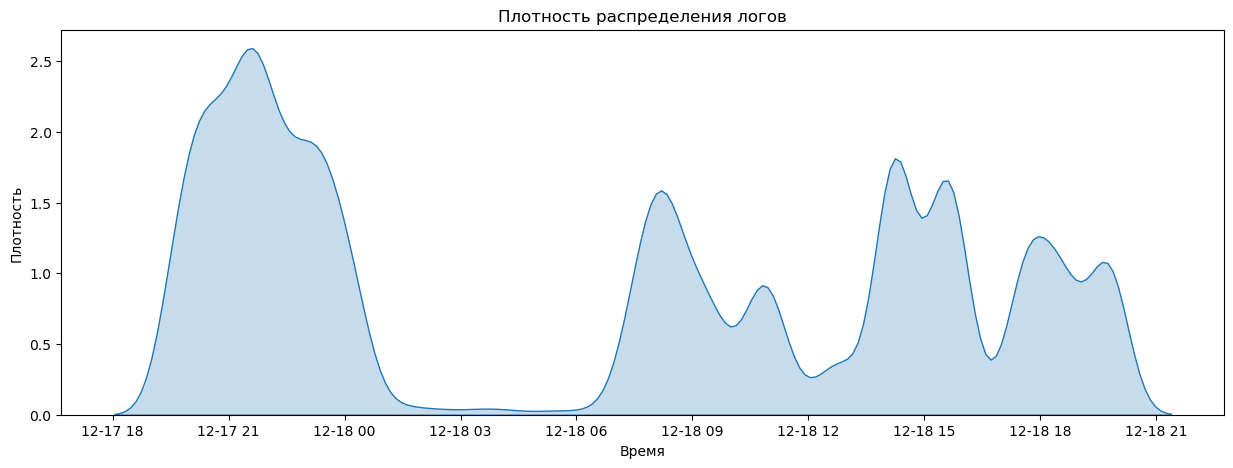

In [46]:
plt.figure(figsize=(15, 5))
sns.kdeplot(data=log_df, x='datetime', fill=True)
plt.title('Плотность распределения логов')
plt.xlabel('Время')
plt.ylabel('Плотность')
plt.show()

Распределение логов по компонентам. Здесь взято по топ-10 самых часто встречаемым компонентам

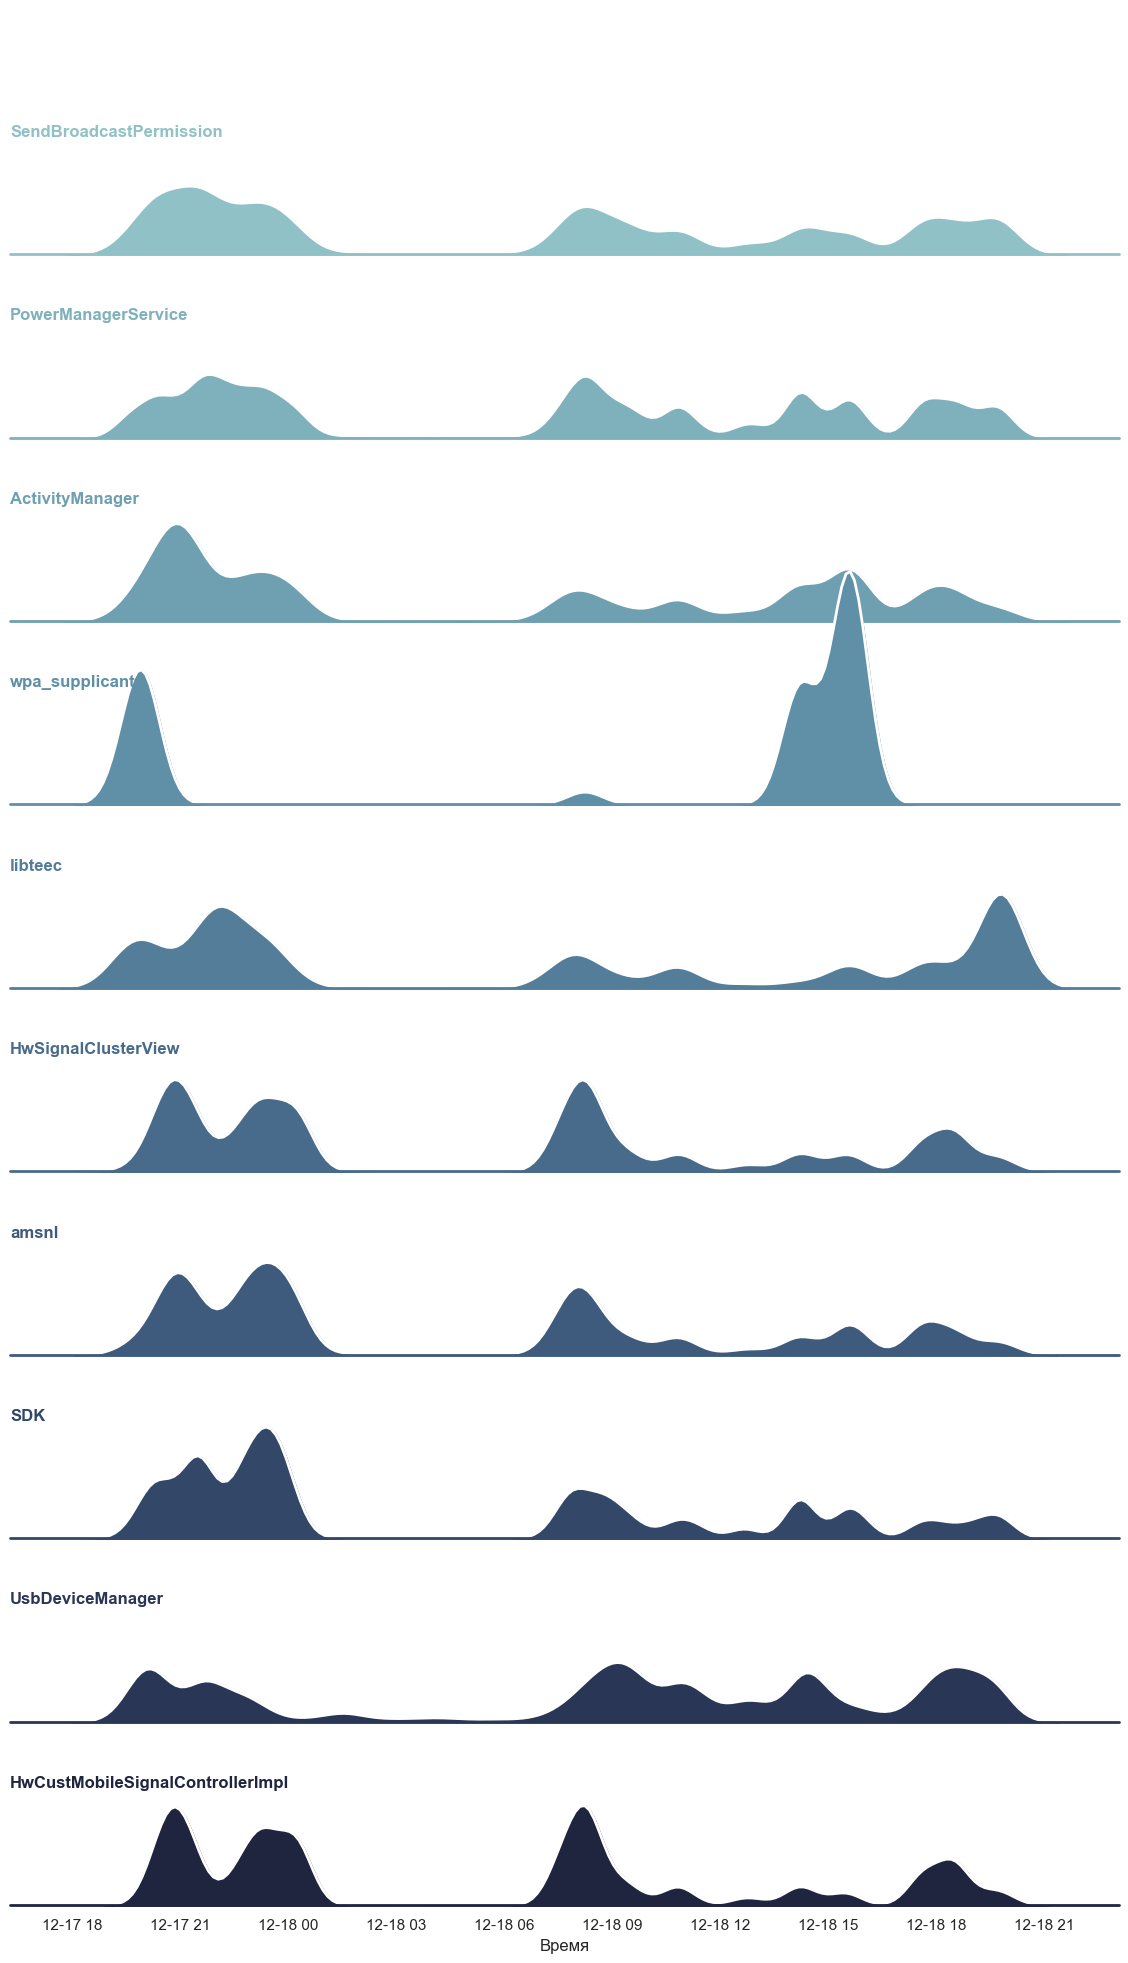

In [47]:
# взято из https://seaborn.pydata.org/examples/kde_ridgeplot.html
def plot_kde(df, hue, components=None, time_col='datetime', top_categories=5):
    sns.set_theme(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})
    if not components:
        components = df[hue].value_counts().head(top_categories).index

    filtered_df = df[df[hue].isin(components)].copy()
    
    palette = sns.cubehelix_palette(len(components), rot=-.25, light=.7)
    g = sns.FacetGrid(filtered_df, row=hue, hue=hue, aspect=6, height=2, palette=palette)

    g.map_dataframe(sns.kdeplot, x=time_col, bw_adjust=.5, clip_on=False, fill=True, alpha=1, lw=1.5)
    g.map_dataframe(sns.kdeplot, x=time_col, clip_on=False, color='w', lw=2, bw_adjust=.5)

    g.refline(y=0, lw=2, ls='-', color=None, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .5, label, fontweight='bold', c=color, ha='left', va='center', transform=ax.transAxes)

    g.map(label, hue)

    g.figure.subplots_adjust(hspace=-.25)
    
    g.set_titles('')
    g.set(yticks=[], ylabel='', xlabel='Время')
    g.despine(bottom=True, left=True)
    plt.show()

plot_kde(log_df, time_col='datetime', hue='component', top_categories=10)


Распределение логов по уровню сообщения

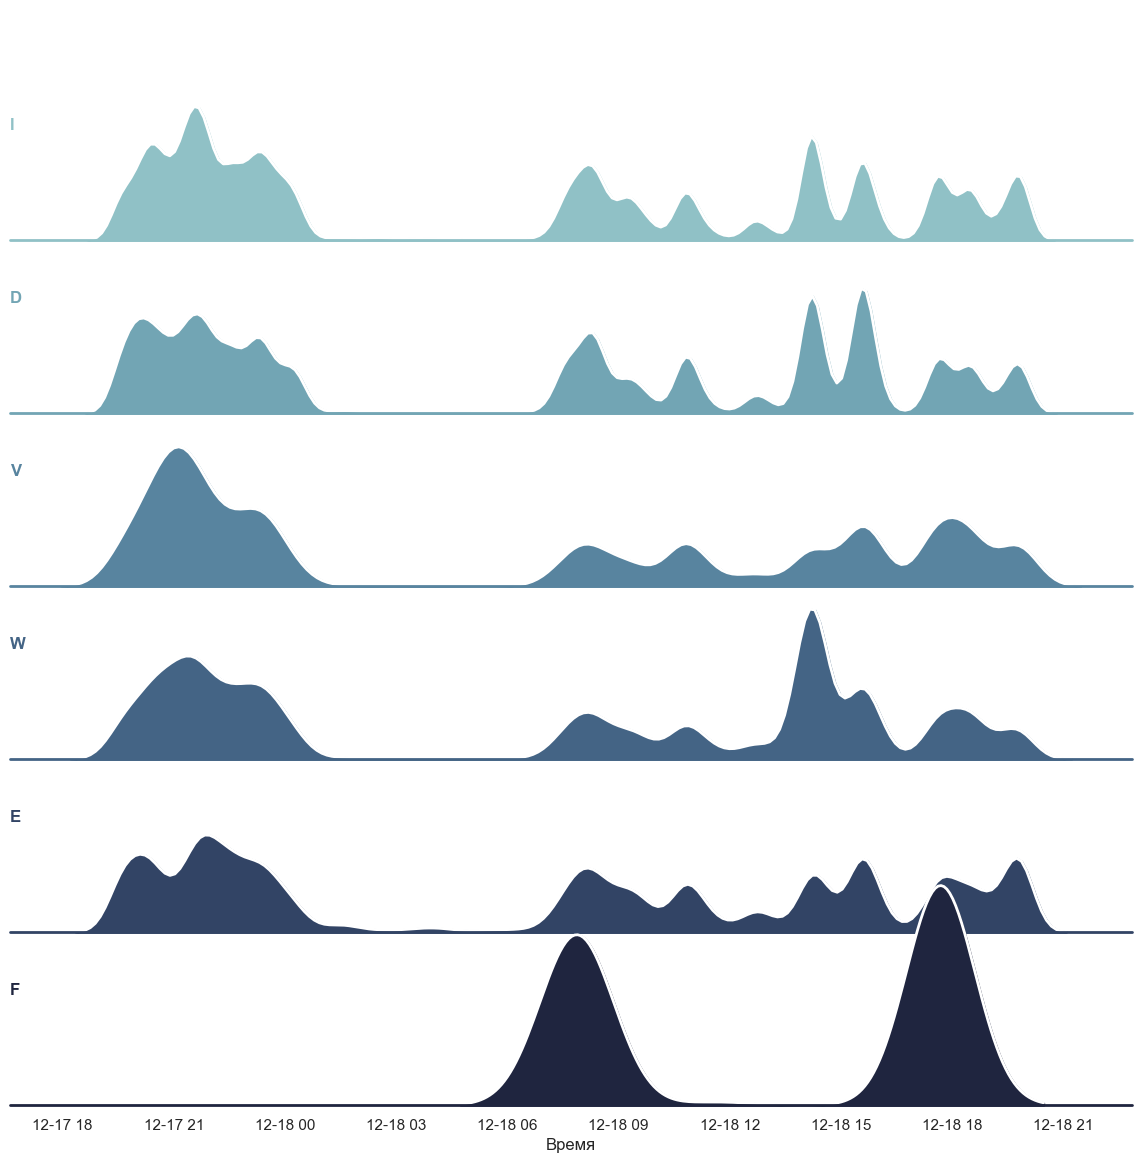

In [48]:
plot_kde(log_df, time_col='datetime', hue='log_level', top_categories=6)

## 3. Очистка и анализ текстовых сообщений

### Тут пока не очень понимаю, что делать и как. Предполагаю, что логичнее сначала сделать темплейты и потом уже анализировать их

Очистка сообщений от ip-адресов, отдельных чисел, хекс-значений, специальных символов, замена множественных пробелов одним.

Тут стоит ещё подумать над тем стоит ли это вообще делать, так как в любом случае будет темплейтинг и там будут уже убраны подобные вещи. 
Возможно стоит заменить только IP или подобные вещи.

Рассмотрим метод Drain. Ниже приведен код для него, стоит отметить, что здесь нет препроцессинга строк, это можно добавить

Информация о методе взята отсюда: [Drain: An Online Log Parsing Approach with Fixed
Depth Tree](https://jiemingzhu.github.io/pub/pjhe_icws2017.pdf)  
Сам пример кода взят отсюда: [logparser/Drain](https://github.com/logpai/logparser/blob/main/logparser/Drain/Drain.py)  
Код немного изменен, но в основном всё бралось оттуда. Переписал просто для себя, чтобы лучше разобраться

In [49]:
import re
from pathlib import Path
import time


# Плохо работает в юпитере
# def print_progress(iteration, total_len):
#     """
#     Прогресс бар для загрузки
#     Написано с помощью DeepSeek
#     :param iteration: номер итерации
#     :param total_len: Общий размер датафрейма
#     :return: None
#     """
#     percent = f'{100 * iteration / total_len:.2f}'
#     filled_length = int(100 * iteration // total_len)
#     bar = '#' * filled_length + '-' * (100 - filled_length)
#     print(f'\r|{bar}| {percent}%', end='', flush=True)


class Node:
    def __init__(self, child_id=None, depth=0, token=None):
        """
        Класс для узла дерева
        :param child_id: id всех лепестков дерева
        :param depth: уровень, на котором находится узел
        :param token: значение узла
        """
        if child_id is None:
            child_id = {}
        self.child_id = child_id
        self.depth = depth
        self.token = token


class LogCluster:
    def __init__(self, log_template='', log_id=None):
        """
        Кластер для хранения схожих логов
        :param log_template: Шаблон лога
        :param log_id: id строк логов с данным шаблоном
        """
        if log_id is None:
            log_id = []
        self.log_template = log_template
        self.log_id = log_id


class DrainParser:
    def __init__(self,
                 log_format,
                 input_dir,
                 output_dir,
                 depth=4,
                 similarity=0.4,
                 max_child=100,
                 ):
        """
        Класс для инициализация парсинга логов с помощью метода Drain
        :param log_format: Формат лога
        :param input_dir: Директория, где находится лог-файл
        :param output_dir: Директория, куда будут записаны результаты
        :param depth: максимальная глубина дерева
        :param similarity: схожесть сообщений в логах
        :param max_child: максимальное количество лепестков дерева с уровня 2 и ниже
        """
        self.log_format = log_format
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.depth = depth - 2
        self.similarity = similarity
        self.max_child = max_child
        self.root_node = Node()
        self.log_df = pd.DataFrame()

    def parse(self, log_name: str) -> None:
        headers, log_format_regex = self.generate_log_format_regex()
        self.log_df = self.load_to_dataframe(log_name, headers, log_format_regex)

        list_clusters = []

        # count = 0

        time_start = time.perf_counter()

        for idx, line in self.log_df.iterrows():
            # len_df = len(self.log_df)

            log_id = line['log_id']
            list_message = line['Content'].strip().split()

            match_cluster = self.tree_search(list_message)

            if match_cluster is None:
                new_cluster = LogCluster(list_message, [log_id])
                list_clusters.append(new_cluster)
                self.add_cluster_to_tree(new_cluster)

            else:
                new_template = self.get_template(list_message, match_cluster.log_template)
                match_cluster.log_id.append(log_id)
                if ' '.join(new_template) != ' '.join(match_cluster.log_template):
                    match_cluster.log_template = new_template

            # count += 1
            # print_progress(count, len_df)

        print(f'\nTime taken: {time.perf_counter() - time_start:.4f} seconds')


        self.save_results(list_clusters, log_name)

    def load_to_dataframe(self, log_name: str, headers: list[str], log_format_regex: re.Pattern[str]) -> pd.DataFrame:
        """
        Загрузка логов в датафрейм
        :param log_name: Наименование файла логов
        :param headers: Заголовки датафрейма
        :param log_format_regex: Регулярное выражение для парсинга строк
        :return: pd.Dataframe()
        """
        df_dict = {header: [] for header in headers}
        skipped_lines = 0

        print('Starting loading logs to dataframe')

        with open(Path(self.input_dir, log_name), 'r', encoding='utf-8') as f:
            for line in f.readlines():
                # В случае отсутствия одного из параметров, сообщение будет пропущено
                try:
                    match = re.match(log_format_regex, line.strip())
                    for header in df_dict:
                        df_dict[header].append(match.group(header).strip())
                except AttributeError:
                    skipped_lines += 1

        df = pd.DataFrame(df_dict)
        df.insert(0, 'log_id', [i for i in range(1, len(df) + 1)])

        print(f'Dataframe was loaded, {skipped_lines} messages was skipped, due to missing parameter in log message')

        return df

    def generate_log_format_regex(self) -> (list[str], re.Pattern[str]):
        """
        Генерация регулярного выражения для парсинга строк
        :return: headers: list, log_format_regex: regular expression
        """
        headers = []
        log_format_regex = ''
        split_log_format = re.split(r'(<[^<>]+>)', self.log_format)

        for i, name in enumerate(split_log_format):
            if i % 2 == 0:
                log_format_regex += re.sub(r'\s+', '\\\s+', name)
            else:
                header = name.strip('<>')
                headers.append(header)
                log_format_regex += rf'(?P<{header}>.+?)'

        log_format_regex = re.compile('^' + log_format_regex + '$')

        return headers, log_format_regex

    def tree_search(self, sequence: list[str]) -> LogCluster or None:
        """
        Поиск наиболее подходящего кластера по дереву
        :param sequence: Список слов в сообщении
        :return: LogCluster or None
        """
        len_sequence = len(sequence)
        matched_cluster = None

        if len_sequence not in self.root_node.child_id:
            return matched_cluster

        parent_node = self.root_node.child_id[len_sequence]
        current_depth = 1
        for token in sequence:
            if current_depth >= self.depth or current_depth > len_sequence:
                break

            if token in parent_node.child_id:
                parent_node = parent_node.child_id[token]
            elif "<*>" in parent_node.child_id:
                parent_node = parent_node.child_id["<*>"]
            else:
                return matched_cluster
            current_depth += 1

        possible_cluster = parent_node.child_id

        matched_cluster = self.find_match(possible_cluster, sequence)

        return matched_cluster

    def find_match(self, cluster: list[LogCluster], sequence: list[str]) -> LogCluster or None:
        """
        Нахождение наиболее схожего кластера
        :param cluster: список из LogCluster
        :param sequence: Список слов в сообщении
        :return: LogCluster or None
        """
        max_similarity = 0
        max_number_of_similar_params = 0
        matched_cluster = None

        for cl in cluster:
            similarity, number_of_parameters = self.check_similarity(cl.log_template, sequence)
            if (similarity > max_similarity or
                    (similarity == max_similarity and number_of_parameters > max_number_of_similar_params)):
                max_similarity = similarity
                max_number_of_similar_params = number_of_parameters
                matched_cluster = cl

        if max_similarity < self.similarity:
            return None

        return matched_cluster

    def check_similarity(self, template: list[str], sequence: list[str]) -> (float, int):
        """
        Проверка схожести c шаблоном
        :param template: шаблон
        :param sequence: список слов в сообщении
        :return: схожесть; количество параметров, отмеченных <*>
        """
        similar_tokens, number_of_parameters = 0, 0
        for token_1, token_2 in zip(template, sequence):
            if token_1 == '<*>':
                number_of_parameters += 1
            elif token_1 == token_2:
                similar_tokens += 1

        similarity = similar_tokens / len(sequence)

        return similarity, number_of_parameters

    def add_cluster_to_tree(self, cluster: LogCluster) -> None:
        """
        Добавление кластера к дереву
        :param cluster: LogCluster
        :return: None
        """
        len_sequence = len(cluster.log_template)
        if len_sequence not in self.root_node.child_id:
            first_layer_node = Node(depth=1, token=len_sequence)
            self.root_node.child_id[len_sequence] = first_layer_node
        else:
            first_layer_node = self.root_node.child_id[len_sequence]

        parent_node = first_layer_node

        current_depth = 1
        for token in cluster.log_template:
            if current_depth >= self.depth or current_depth > len_sequence:
                if len(parent_node.child_id) == 0:
                    parent_node.child_id = [cluster]
                else:
                    parent_node.child_id.append(cluster)
                break

            if token not in parent_node.child_id:
                current_number_of_child = len(parent_node.child_id)

                if not any(char.isdigit() for char in token):
                    if '<*>' in parent_node.child_id:
                        if current_number_of_child < self.max_child:
                            new_node = Node(depth=current_depth + 1, token=token)
                            parent_node.child_id[token] = new_node
                            parent_node = new_node
                        else:
                            parent_node = parent_node.child_id['<*>']
                    else:
                        if current_number_of_child + 1 < self.max_child:
                            new_node = Node(depth=current_depth + 1, token=token)
                            parent_node.child_id[token] = new_node
                            parent_node = new_node
                        elif current_number_of_child + 1 == self.max_child:
                            new_node = Node(depth=current_depth + 1, token='<*>')
                            parent_node.child_id['<*>'] = new_node
                            parent_node = new_node
                else:
                    if '<*>' in parent_node.child_id:
                        parent_node = parent_node.child_id['<*>']
                    else:
                        new_node = Node(depth=current_depth + 1, token='<*>')
                        parent_node.child_id['<*>'] = new_node
                        parent_node = new_node
            else:
                parent_node = parent_node.child_id[token]

            current_depth += 1

    def get_template(self, new_sequence: list[str], old_sequence: list[str]) -> list[str]:
        """
        Создание шаблона сообщения
        :param new_sequence: Новое сообщение в текущем логе
        :param old_sequence: Старое сообщение, которое хранится в шаблоне кластера
        :return: Новый шаблон
        """
        new_template = []

        for word_1, word_2 in zip(new_sequence, old_sequence):
            if word_1 == word_2:
                new_template.append(word_1)
            else:
                new_template.append('<*>')

        return new_template

    def save_results(self, clusters: list[LogCluster], log_file: str) -> None:
        """
        Сохранение результатов в формате csv
        :param clusters: все добавленные кластеры
        :param log_file: имя файла
        :return: None
        """
        log_templates = [pd.NA] * len(self.log_df)
        log_templates_id = [pd.NA] * len(self.log_df)
        df_events = []

        for cluster in clusters:
            template = ' '.join(cluster.log_template)
            occurrence = len(cluster.log_id)
            hex_id = int(str(hash(template))[:8])
            for idx in cluster.log_id:
                idx -= 1
                log_templates[idx] = template
                log_templates_id[idx] = hex_id
            df_events.append([hex_id, template, occurrence])

        self.log_df['Event_id'] = log_templates_id
        self.log_df['Event_template'] = log_templates
        self.log_df['parameters'] = self.log_df.apply(self.get_parameter_list, axis=1)

        self.log_df.to_csv(Path(self.output_dir, log_file + '_structured_test.csv'), index=False)

    def get_parameter_list(self, row) -> list:
        """
        Для создание столбца параметров, которые скрываются за <*>
        :param row: строка из DataFrame
        :return: список подставляемых значений
        """
        result_row = []
        if '<*>' not in row['Event_template']:
            return result_row

        regex = re.sub(r'([^A-Za-z0-9])', r'\\\g<1>', row['Event_template'])
        regex = re.sub(r'\\\s+', r'\\s+', regex)
        regex = '^' + re.sub(r'\\<\\\*\\>', r'(.*?)', regex) + '$'
        result_row = re.findall(regex, row['Content'])
        result_row = list(result_row[0]) if isinstance(result_row[0], tuple) else [result_row[0]]
        return result_row

<>:154: SyntaxWarning: invalid escape sequence '\s'
<>:154: SyntaxWarning: invalid escape sequence '\s'
C:\Users\user\AppData\Local\Temp\ipykernel_8616\2074602194.py:154: SyntaxWarning: invalid escape sequence '\s'
  log_format_regex += re.sub(r'\s+', '\\\s+', name)


In [50]:
inp_dir = ''
out_dir = ''
log = 'Android.log'
format_log = '<Date> <Time> <Pid> <Tid> <Level> <Component>: <Content>'
drain = DrainParser(format_log, inp_dir, out_dir, similarity=0.4, depth=4, max_child=100)
drain.parse(log)

Starting loading logs to dataframe
Dataframe was loaded, 67879 messages was skipped, due to missing parameter in log message

Time taken: 1007.3108 seconds


Тут стоит отметить, что количество пропусков строк отличается от моего изначального варианта, значит либо я где-то косячу, либо регулярка пропускает какие-то значения и у нас есть пустые сообщения. Тут стоит подробнее разобраться.

In [52]:
stractured_log = pd.read_csv('Android.log_structured_test.csv', encoding='utf-8')
display(stractured_log)

,log_id,Date,Time,Pid,Tid,Level,Component,Content,Event_id,Event_template,parameters
0,1,12-17,19:31:36.263,1795,1825,I,PowerManager_screenOn,DisplayPowerStatesetColorFadeLevel: level=1.0,-8532474,DisplayPowerStatesetColorFadeLevel: <*>,['level=1.0']
1,2,12-17,19:31:36.263,5224,5283,I,SendBroadcastPermission,action:android.com.huawei.bone.NOTIFY_SPORT_DA...,-1546295,action:android.com.huawei.bone.NOTIFY_SPORT_DA...,[]
2,3,12-17,19:31:36.264,1795,1825,D,DisplayPowerController,"Animating brightness: target=21, rate=40",-1867425,Animating brightness: <*> <*>,"['target=21,', 'rate=40']"
3,4,12-17,19:31:36.264,1795,1825,I,PowerManager_screenOn,DisplayPowerController updatePowerState mPendi...,48284096,DisplayPowerController updatePowerState <*> <*...,"['mPendingRequestLocked=policy=BRIGHT,', 'useP..."
4,5,12-17,19:31:36.264,1795,2750,I,PowerManager_screenOn,DisplayPowerState Updating screen state: state...,-6874682,DisplayPowerState Updating screen state: <*> <*>,"['state=ON,', 'backlight=823']"
...,...,...,...,...,...,...,...,...,...,...,...
1487121,1487122,12-18,19:53:49.399,2852,2852,I,ToggleSlider,mSeekListener onProgressChanged progress:1574 ...,33210477,mSeekListener onProgressChanged <*> fromUser:f...,['progress:1574']
1487122,1487123,12-18,19:53:49.399,2852,2852,I,ToggleSlider,mSeekListener onProgressChanged progress:1574 ...,33210477,mSeekListener onProgressChanged <*> fromUser:f...,['progress:1574']
1487123,1487124,12-18,19:53:49.406,1795,2750,I,HwLightsService,back light level before map = 534,-8646273,back light level before map = <*>,['534']
1487124,1487125,12-18,19:53:49.406,1795,2750,D,HW_DISPLAY_EFFECT,"presently, hw_update_color_temp_for_rg_led int...",42439324,"presently, hw_update_color_temp_for_rg_led int...",[]


In [56]:
# Количество уникальных шаблонов
stractured_log['Event_id'].nunique()

29929